# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
import matplotlib
from sklearn.metrics import f1_score


%matplotlib inline


In [2]:
# create a Spark session
#set parameters
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()


spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1595346769772'),
 ('spark.master', 'local[*]'),
 ('spark.driver.port', '45623'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '19f9a8c345c3')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#extract the data from the json file
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

#to be able to use spark sql, a temp view is created
df.createOrReplaceTempView("log_table")

In [4]:
#take a look
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
#let's see the columns and basic statistics
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

As can be see in the summary of the table, there are totally 286500 rows and no session or user id is missing.
Another number can be pointed from the summary which is 278154. There are about 7k missing values. It is noticed, these number exists in user related fields like last name, gender etc. Moreover, min value for user id is shown as empty. THerefore, my assumption here is that 278154 is the number of rows in which user id is not empty.
Let's ensure it.

In [7]:
df.createOrReplaceTempView("log_table")
spark.sql('''select count(*) from log_table where userId != '' ''').show()

+--------+
|count(1)|
+--------+
|  278154|
+--------+



Above code has returned the same value, therefore our assumption can't be rejected.
Let's explore some more about empty users and than we can decide whether we need to keep them or clean.

In [8]:
#Explore the pages that empty users visits
spark.sql('''select distinct page from log_table where userId == '' ''').show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



Above results shows blank users do not listen music. They can be unsigned users. We need to understand some more to decide drop the values. We can also see that registration columns are null for the blank users.

In [9]:
#let's explore blank users behaviours
spark.sql('''select distinct auth from log_table where userId == '' ''').show()
spark.sql('''select distinct level from log_table where userId == '' ''').show()
#They only have two auths which are Logged Out and Guest. 
#However both free and paid level are available unpectedly.
#Therefore explore some more
#lets ensure null values for registration belong to blank users.
spark.sql('''select distinct registration from log_table where userId == '' ''').show()
#dive deeper
spark.sql('''select * from log_table where userId == '' and auth = 'Guest' and level = 'paid' ''').show()


+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------------+
|registration|
+------------+
|        null|
+------------+

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



Above results shows that all paid blank users have the auth 'logged out'.
Therefore my assumption here is that when users logged out their level (whether paid or free) is hold for this stage.
Now check all these auth has no other user than blanks.

In [10]:
spark.sql('''select distinct userID from log_table where auth in ('Logged Out', 'Guest') ''').show()


+------+
|userID|
+------+
|      |
+------+



In this project we try to understand churn behaviours of users.
Since blank users are guests and ones who logged out yet, we do not need to take these into consideration since they become anonymous and cannot listen music anymore.

In [11]:
#drop blank users
cleaned_df = spark.sql('''select * from log_table where userId != ''  ''')
#replace the existing table
cleaned_df.createOrReplaceTempView("log_table")

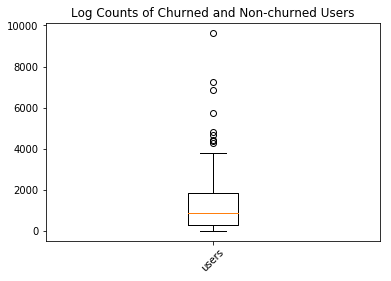

In [12]:
#Lets take a look users' log numbers
logCounts = spark.sql("select userID, count(*) as logCount from log_Table group by userId").toPandas()

fig2, ax2 = plt.subplots()
ax2.set_title('Log Counts of Churned and Non-churned Users')
ax2.boxplot(logCounts['logCount'])

ax2.set_xticklabels(['users'] , rotation= 45)
plt.show()




Plot shows that users' activity varies so much. In order to avoid miss fitting of models, least and most active 5% of users will be removed.

In [13]:
#hold 5th quantiles of data
q95 = logCounts['logCount'].quantile(q=0.95)
q05 = logCounts['logCount'].quantile(q=0.05)

#removing the users that are out of range
df_withConfidenceInt = spark.sql('''select * from log_table lt where exists
                (select userID, count(*) as logCount from log_Table where userId = lt.userId
                group by userId having logCount>{}
                and logCount<{})'''.format(q05, q95))


df_withConfidenceInt.createOrReplaceTempView("log_table")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
#Lets explore the Cancellation Confirmation Page
spark.sql('''select userId, page, level, status, ts from log_table where page = 'Cancellation Confirmation'  ''').show()
#18, 32, 125, 105, 107, 106, 103

#spark.sql('''select userId, page, level, status, ts from log_table where userId = 106 order by ts ''').collect()

spark.sql('''select count(distinct tbl1.userId) from log_table tbl1, log_table tbl2
            where tbl1.userId = tbl2.userId and tbl1.ts > tbl2.ts and tbl2.page = 'Cancellation Confirmation'
            ''').show()

cancels = spark.sql('''select userID, ts as cancelTime, level from log_table 
            where page = 'Cancellation Confirmation'  ''')

cancels.createOrReplaceTempView("cancellations")


spark.sql('''select * from cancellations ''').show()


+------+--------------------+-----+------+-------------+
|userId|                page|level|status|           ts|
+------+--------------------+-----+------+-------------+
|    51|Cancellation Conf...| paid|   200|1539761972000|
|    54|Cancellation Conf...| paid|   200|1542051608000|
|100014|Cancellation Conf...| paid|   200|1542740649000|
|   101|Cancellation Conf...| paid|   200|1539729037000|
|100021|Cancellation Conf...| free|   200|1543143782000|
|    73|Cancellation Conf...| paid|   200|1540402387000|
|    87|Cancellation Conf...| paid|   200|1540050556000|
|     3|Cancellation Conf...| paid|   200|1540875543000|
|    28|Cancellation Conf...| paid|   200|1541463632000|
|100022|Cancellation Conf...| free|   200|1542038645000|
|100025|Cancellation Conf...| free|   200|1540299152000|
|300007|Cancellation Conf...| paid|   200|1538705338000|
|    18|Cancellation Conf...| paid|   200|1538943990000|
|    70|Cancellation Conf...| paid|   200|1542234867000|
|100005|Cancellation Conf...| f

We see the Cancellation Approval logs however this does not give a clear idea.
We can watch behaviours of some users who has visits cancellation confirmation page. We can use the above user like 18, 32, 125, 105, 107, 106, 103 etc.

In [15]:
#observe with different users who has visited cancellation confirmation page.
spark.sql('''select userId, page, level, status, ts from log_table where userId = 106 order by ts ''').collect()

[Row(userId='106', page='Home', level='free', status=200, ts=1538586664000),
 Row(userId='106', page='Logout', level='free', status=307, ts=1538586665000),
 Row(userId='106', page='Home', level='free', status=200, ts=1538587004000),
 Row(userId='106', page='NextSong', level='free', status=200, ts=1538587055000),
 Row(userId='106', page='NextSong', level='free', status=200, ts=1538587212000),
 Row(userId='106', page='NextSong', level='free', status=200, ts=1538587329000),
 Row(userId='106', page='NextSong', level='free', status=200, ts=1538587568000),
 Row(userId='106', page='Thumbs Up', level='free', status=307, ts=1538587569000),
 Row(userId='106', page='NextSong', level='free', status=200, ts=1538587845000),
 Row(userId='106', page='NextSong', level='free', status=200, ts=1538588053000),
 Row(userId='106', page='NextSong', level='free', status=200, ts=1538588199000),
 Row(userId='106', page='NextSong', level='free', status=200, ts=1538588466000),
 Row(userId='106', page='NextSong', l

Now things are getting more clear! It seem that Cancellation Confirmation is the last activity of the users. Therefore we can conclude that members who visits cancellation confirmation page are ones who delete their accounts, or cancel their membership, so do not have any more log.
Let's ensure this.

In [16]:
#extract the distinct users who has log after cancellation confirmation.
spark.sql('''select count(distinct tbl1.userId) from log_table tbl1, log_table tbl2
            where tbl1.userId = tbl2.userId and tbl1.ts > tbl2.ts and tbl2.page = 'Cancellation Confirmation'
            ''').show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                     0|
+----------------------+



It seems assummtion was right. Now it would be better if we store cancellation log in a separate table, so we can use this table later.

In [17]:
#creating a cancellation table that hold cancellation acitivities.
cancels = spark.sql('''select userID, ts as cancelTime, level from log_table 
            where page = 'Cancellation Confirmation'  ''')
cancels.createOrReplaceTempView("cancellations")
spark.sql('''select * from cancellations ''').show()

+------+-------------+-----+
|userID|   cancelTime|level|
+------+-------------+-----+
|    51|1539761972000| paid|
|    54|1542051608000| paid|
|100014|1542740649000| paid|
|   101|1539729037000| paid|
|100021|1543143782000| free|
|    73|1540402387000| paid|
|    87|1540050556000| paid|
|     3|1540875543000| paid|
|    28|1541463632000| paid|
|100022|1542038645000| free|
|100025|1540299152000| free|
|300007|1538705338000| paid|
|    18|1538943990000| paid|
|    70|1542234867000| paid|
|100005|1539971825000| free|
|    17|1539465584000| paid|
|100007|1543491909000| paid|
|300001|1543009344000| paid|
|100009|1540611104000| free|
|100015|1543073753000| paid|
+------+-------------+-----+
only showing top 20 rows



 Here, actually we have defined the churn step. If a user has Cancellation Confirmation log or exists in cancellation table, s/he can be thought as churned.
 Now, lets explore more about churned users.

In [18]:
#find the number of songs that churned users has listened
spark.sql('''select userId, count(distinct(*)) as cnt from log_table 
            where userId in (select userId from cancellations)
            and page = 'NextSong'
            group by userId
            order by cnt desc
            ''').show()

+------+----+
|userId| cnt|
+------+----+
|    54|2841|
|    51|2111|
|   101|1797|
|300001|1749|
|    53|1746|
|    58|1694|
|    70|1490|
|    28|1457|
|200021|1227|
|200020|1169|
|100013|1131|
|   103|1073|
|    17| 927|
|    12| 867|
|   106| 839|
|100015| 800|
|    87| 767|
|   105| 764|
|   121| 726|
|100022| 681|
+------+----+
only showing top 20 rows



Only numbers are so insufficient to discover things. Some periodical changes can provide deeper insights.

In [19]:
#lets explore monthly data of the churned users
spark.sql('''select userId, trunc(to_date(timestamp(ts/1000)), 'Month') as mnth, count(*)
            from log_table
            where userId in (select userId from cancellations)
            and page = 'NextSong'
            group by userId, trunc(to_date(timestamp(ts/1000)), 'Month')
            order by userId, mnth ''').show()


+------+----------+--------+
|userId|      mnth|count(1)|
+------+----------+--------+
|100001|2018-10-01|     133|
|100003|2018-10-01|      51|
|100005|2018-10-01|     154|
|100007|2018-10-01|     222|
|100007|2018-11-01|     201|
|100009|2018-10-01|     518|
|100012|2018-10-01|     419|
|100012|2018-11-01|      57|
|100013|2018-10-01|    1086|
|100013|2018-11-01|      45|
|100014|2018-10-01|     195|
|100014|2018-11-01|      62|
|100015|2018-10-01|     572|
|100015|2018-11-01|     228|
|100017|2018-10-01|      52|
|100019|2018-10-01|      62|
|100021|2018-10-01|      68|
|100021|2018-11-01|     162|
|100022|2018-10-01|     394|
|100022|2018-11-01|     287|
+------+----------+--------+
only showing top 20 rows



It is seems monthly period is so limited for this data. Most of the users has logs only in one month, probably because data include only a few month.
Moreover, it would be better if can see the different behaviours between churned and unchurned users. We can start from their hourly trends.

In [20]:
#exploring the hourly trends of users. Creating a function that extract hour from timestamp.
spark.udf.register("get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour))


<function __main__.<lambda>(x)>

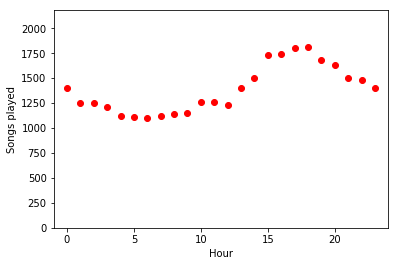

In [21]:
#plotting hourly trends of churned users
songs_in_hour_for_churned = spark.sql('''
          SELECT get_hour(ts) AS hour, COUNT(*) as plays_per_hour
          FROM log_table
          WHERE page = "NextSong"
          and userId in (select userId from cancellations)
          GROUP BY hour
          ORDER BY cast(hour as int) ASC
          '''
          )


songs_in_hour_churned_pd = songs_in_hour_for_churned.toPandas()

plt.plot(songs_in_hour_churned_pd["plays_per_hour"], 'ro')
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_churned_pd["plays_per_hour"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

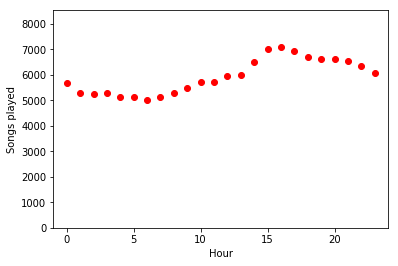

In [22]:
#plotting hourly trends of churned users
songs_in_hour_for_unchurned = spark.sql('''
          SELECT get_hour(ts) AS hour, COUNT(*) as plays_per_hour
          FROM log_table
          WHERE page = "NextSong"
          and userId not in (select userId from cancellations)
          GROUP BY hour
          ORDER BY cast(hour as int) ASC
          '''
          )


songs_in_hour_unchurned_pd = songs_in_hour_for_unchurned.toPandas()

plt.plot(songs_in_hour_unchurned_pd["plays_per_hour"], 'ro')
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_unchurned_pd["plays_per_hour"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

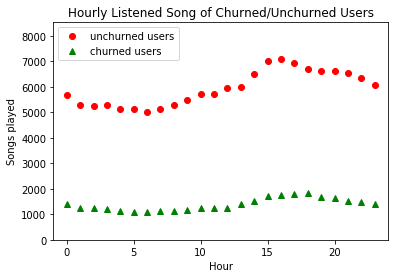

In [23]:
data = [songs_in_hour_unchurned_pd["plays_per_hour"], \
        songs_in_hour_churned_pd["plays_per_hour"]]
fig2, ax2 = plt.subplots()

plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_unchurned_pd["plays_per_hour"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

ax2.set_title('Hourly Listened Song of Churned/Unchurned Users')
plt.plot(songs_in_hour_unchurned_pd["plays_per_hour"], 'ro', songs_in_hour_churned_pd["plays_per_hour"], 'g^')
ax2.legend(['unchurned users', 'churned users'])
plt.show()

Above graphs shows there is no considerable different between two groups' beahviours. Only difference is the number of total songs but it is most probaly because of churned users build only a small proprotion of the all users.


In [24]:
spark.sql('''select userId,
sum(case when page == 'NextSong' then 1 else 0 end) as TotalListenedSongs,
sum(case when page == 'Thumbs Up' then 1 else 0 end) as likes,
sum(case when page == 'Thumbs Down' then 1 else 0 end) as dislikes,
sum(case when page == 'Cancellation Confirmation' then 1 else 0 end) as ifChurned
from log_table
group by userId
''').show()


+------+------------------+-----+--------+---------+
|userId|TotalListenedSongs|likes|dislikes|ifChurned|
+------+------------------+-----+--------+---------+
|100010|               275|   17|       5|        0|
|200002|               387|   21|       6|        0|
|    51|              2111|  100|      21|        1|
|     7|               150|    7|       1|        0|
|    15|              1914|   81|      14|        0|
|    54|              2841|  163|      29|        1|
|   155|               820|   58|       3|        0|
|100014|               257|   17|       3|        1|
|   132|              1928|   96|      17|        0|
|   154|                84|   11|       0|        0|
|   101|              1797|   86|      16|        1|
|    11|               647|   40|       9|        0|
|   138|              2070|   95|      24|        0|
|100021|               230|   11|       5|        1|
|    69|              1125|   72|       9|        0|
|   112|               215|    9|       3|    

Another point is home visits of users. Here I will explore home visits and how many songs they listen home-to-home.

In [25]:
#creating a new column called as period to show home visits of  users
#firstlt home visits are marked
is_home = spark.sql("SELECT userID, page, ts, CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS is_home FROM log_table \
            WHERE (page = 'NextSong') or (page = 'Home') \
            ")

# keep the results in a new view
is_home.createOrReplaceTempView("is_home_table")

# find the cumulative sum over the is_home column
cumulative_sum = spark.sql("SELECT *, SUM(is_home) OVER \
    (PARTITION BY userID ORDER BY ts ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period \
    FROM is_home_table")

# keep the results in a view
cumulative_sum.createOrReplaceTempView("period_table")

## find the average count for NextSong
spark.sql("SELECT userId, period, COUNT(*) AS count_results FROM period_table \
GROUP BY userID, period, page HAVING page = 'NextSong' ").show()

+------+------+-------------+
|userId|period|count_results|
+------+------+-------------+
|100010|     0|           35|
|100010|     1|            3|
|100010|     2|            7|
|100010|     3|           11|
|100010|     4|           20|
|100010|     5|            9|
|100010|     6|           50|
|100010|     7|           14|
|100010|     8|           38|
|100010|     9|           63|
|100010|    10|            1|
|100010|    11|           24|
|200002|     0|           10|
|200002|     1|            1|
|200002|     2|           13|
|200002|     3|           22|
|200002|     4|           12|
|200002|     5|            1|
|200002|     6|           28|
|200002|     8|           34|
+------+------+-------------+
only showing top 20 rows



Now we can find average number of listened songs per session for each user. Afterwards, we can add this column to user table.

In [26]:
spark.sql("SELECT userId, max(period) + 1 as homeVisits, bround(count(*)/count(distinct period), 2) as av_song_per_ses \
            FROM period_table \
WHERE page = 'NextSong' GROUP BY userID  ").show()

+------+----------+---------------+
|userId|homeVisits|av_song_per_ses|
+------+----------+---------------+
|100010|        12|          22.92|
|200002|        21|          19.35|
|    51|        76|          29.32|
|     7|        11|          13.64|
|    15|        94|          21.27|
|    54|       129|          24.92|
|   155|        30|          29.29|
|100014|         8|          32.12|
|   132|        83|          24.72|
|   154|         7|           14.0|
|   101|        75|          24.96|
|    11|        38|          17.49|
|   138|        72|          31.36|
|100021|        16|          14.38|
|    69|        50|          23.44|
|   112|        17|          16.54|
|    73|        16|          25.13|
|    87|        57|          14.47|
|200010|        15|           15.8|
|    64|         8|           7.67|
+------+----------+---------------+
only showing top 20 rows



Before, I have tried to find monthly statistics but they were not so useful since there are only a few monthsç
Therefore, now I will try to find statistics about last week.

In [27]:
#first I write the same function, but this to convert timestamp to day.
spark.udf.register("get_day", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).day))
spark.sql('''
          SELECT DATE_SUB(max(to_date(timestamp(ts/1000))), 7) as day
          FROM log_table 
          
          '''
          ).show()

+----------+
|       day|
+----------+
|2018-11-26|
+----------+



In [28]:
#I have found date a week before the last acitivity. Now I put it as constant, later it should be made more flexible.
user_df = spark.sql('''select *, bround(LastWeekListenedSongs / TotalListenedSongs, 2) as LastWeekSongsRate from
(select userId,
sum(case when page == 'NextSong' then 1 else 0 end) as TotalListenedSongs,
sum(case when (page == 'NextSong') and (to_date(timestamp(ts/1000)) > cast('2018-11-26' as date)) then 1 else 0 end) as LastWeekListenedSongs,
sum(case when page == 'Thumbs Up' then 1 else 0 end) as likes,
sum(case when page == 'Thumbs Down' then 1 else 0 end) as dislikes,
sum(case when page == 'Cancellation Confirmation' then 1 else 0 end) as ifChurned
from log_table
group by userId)
''')

To understand the effect of this ratio to churn, we can use visualization. I choose box plot to see the difference between churned and unchurned users.

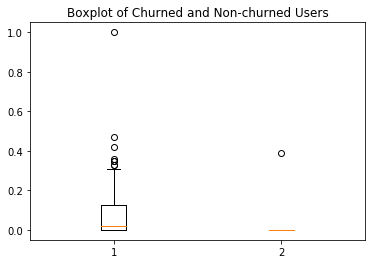

In [29]:
user_df.createOrReplaceTempView('UserTable')
plot_data = spark.sql('''select LastWeekSongsRate, ifChurned from UserTable''')
plot_data_pd = plot_data.toPandas()

data = [plot_data_pd[plot_data_pd['ifChurned'] == 0]['LastWeekSongsRate'], plot_data_pd[plot_data_pd['ifChurned'] == 1]['LastWeekSongsRate']]
fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot of Churned and Non-churned Users')
ax1.boxplot(data)

plt.show()


In [30]:
print(plot_data_pd[plot_data_pd['ifChurned'] == 0]['LastWeekSongsRate'].mean())
print(plot_data_pd[plot_data_pd['ifChurned'] == 1]['LastWeekSongsRate'].mean())

0.0809090909091
0.00829787234043


There seems considerably an important difference between these ratios between two groups.
However, the ratio for churned users are so close 0. This point seems suspicious to me, then I presume it is probably because most of the churned users has already before the last week of logs started.
Therefore, I changed my method here, and decided to calculate this ratio for the last week of churned users. I maintained same method for unchurned users.

In [31]:
#Now I expand the user table, adding last feautures we just calculated + last activity
user_df2 = spark.sql("SELECT userId, max(period) + 1 as homeVisits, bround(count(*)/count(distinct period), 2) as av_song_per_ses, \
            to_date(timestamp(max(ts)/1000)) last_activity \
            FROM period_table \
WHERE page = 'NextSong' GROUP BY userID  ")

user_df = user_df.join(user_df2, on=['userId'], how='inner')
user_df.createOrReplaceTempView('UserTable')
user_df.show()

+------+------------------+---------------------+-----+--------+---------+-----------------+----------+---------------+-------------+
|userId|TotalListenedSongs|LastWeekListenedSongs|likes|dislikes|ifChurned|LastWeekSongsRate|homeVisits|av_song_per_ses|last_activity|
+------+------------------+---------------------+-----+--------+---------+-----------------+----------+---------------+-------------+
|100010|               275|                    0|   17|       5|        0|              0.0|        12|          22.92|   2018-11-21|
|200002|               387|                    0|   21|       6|        0|              0.0|        21|          19.35|   2018-11-15|
|    51|              2111|                    0|  100|      21|        1|              0.0|        76|          29.32|   2018-10-17|
|     7|               150|                    0|    7|       1|        0|              0.0|        11|          13.64|   2018-11-23|
|    15|              1914|                    0|   81|      1

In [32]:
#store the last of the logs to be able to map days. 
#In th actual data today function can be used to predict future instead of collecting this value.
last_day = spark.sql("select to_date(timestamp(max(ts)/1000)) from log_table").collect()[0][0]

#now we are creating two columns:
#dt --> date of log
#mappedDay --> distance days from the last day. In real, this data can stored in a view so no need to calculate each time.
df = spark.sql('''select *, datediff(to_date('{}'),dt) as mappedDay from
            (select *, to_date(timestamp(ts/1000)) as dt
            from log_table) order by ts'''.format(last_day)
         )

#update the log_table
df.createOrReplaceTempView("log_table")

In [33]:
temp_user = spark.sql("select * from (select 3 as userId) where userId=2")
periodicUserStatistics = spark.sql("select * from (select 3 as userId, \
                    1 as onlineDays, 1 as likes, 1 as dislikes, 1 as listenedSongs, 1 as HomeVisits, \
                    1 as differentArtists, 1 as Errors, 1 as cycle, 1 as ifChurned) where userId=2")

for i in reversed(range(6)):
        
        
    
    #label table will hold whether the users churn 'test_time' days after the origin.
    label_table = spark.sql('''select userId, {} as cycle,
    sum(case when page == 'Cancellation Confirmation' then 1 else 0 end) as ifChurned
    from log_table
    where mappedDay < {} and mappedDay >= {}
    group by userId '''.format(i, i*10+10, i*10))    
    
    #there will be users who churn in train period. It will be meaningless to include these users.
    #Therefore these users will be excluded.
    churned_users = spark.sql('''select userId from (select userId,
    sum(case when page == 'Cancellation Confirmation' then 1 else 0 end) as ifChurned
    from log_table
    where mappedDay < {} and mappedDay >= {}
    group by userId) where ifChurned=1 '''.format(i*10+20, i*10+10))
    
    churned_users.createOrReplaceTempView("churnedUsers")
    
    #Here features are stored. If any new feature is decided to be added, it should be done here.
    features_table = spark.sql('''select userId, count(distinct(dt)) onlineDays,
    sum(case when page == 'Thumbs Up' then 1 else 0 end) as likes,
    sum(case when page == 'Thumbs Down' then 1 else 0 end) as dislikes,
    sum(case when page == 'NextSong' then 1 else 0 end) as listenedSongs,
    sum(case when page == 'Home' then 1 else 0 end) as HomeVisits,
    sum(case when page == 'Error' then 1 else 0 end) as Errors,
    count(distinct(artist)) as differentArtists
    from log_table
    where mappedDay < {} and mappedDay >= {}
    and userId not in (select userId from churnedUsers)
    group by userId'''.format(i*10+20, i*10+10))
    
    temp_user = temp_user.subtract(churned_users)       
    
    
    #create the output dataframe
    #full join of users and feautures table since there can be old users who has no log for the train time
    #and also be new users who only exists in features table.
    #Full join of these two table is lef joined with the label table. Because there may be users who will
    #sign up and churn in the test period. Since we thought origin as today we dont have any knowledge about them yet.
    agg_table = temp_user.join(features_table, on=['userId'], how='full').join(label_table, on=['userId'], how='left').na.fill(0)
    
    
    temp_user = agg_table.select('userId').distinct() 
    
    periodicUserStatistics = periodicUserStatistics.union(agg_table)
        
        
   

I first notice most of data is 0 for weekly report. Probably, in general, people are using the application for a few day and never touch again for a while.
Another important point is that some portion of churned members, seems to listen their all music in their last week. (Last week ratios). My conclusion is that people are giving a last chance to the application then they churn. Maybe people are not so aware that they are paying for the application till the next time they enter the application, or after some time without listening any song, they enter the applciation and have a bad experience.
THerefore, in my opinion we should include these feautes in our model.

ANother feaute might be likes and dislikes. Probably, a member who interact less with these pages, can be more likely to churn. Here likes are in absoutely reverse direction from churn behaviour. However while thumbs down represents a situation of dislike, they also represents an interaction with the application. Let's observe boxplots for churned and unchurned users.

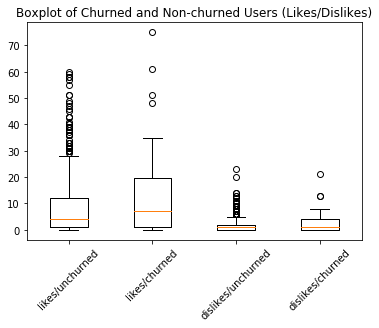

In [34]:
stt_tbl_pd = periodicUserStatistics.toPandas()

data = [np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 0]['likes']), \
        np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 1]['likes']), \
        np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 0]['dislikes']), \
        np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 1]['dislikes'])]

fig2, ax2 = plt.subplots()
#fig2.set_size_inches(18.5, 10.5)
ax2.set_title('Boxplot of Churned and Non-churned Users (Likes/Dislikes)')
ax2.boxplot(data)
ax2.set_xticklabels(['likes/unchurned', 'likes/churned', 'dislikes/unchurned', 'dislikes/churned'] , rotation= 45)
plt.show()

As can be seen churned users have less interaction in respect to likes/dislikes. These shoould be included in the model.

The time period that is considered to reflect churn period can be discussed but I assume it as 3 weeks for now. Let we can watch the total number of song listened in the last 3 weeks.

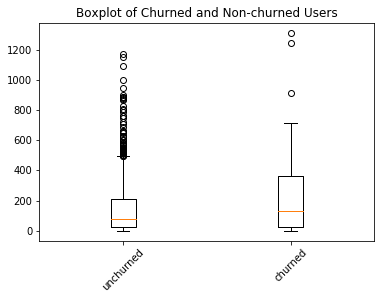

In [35]:
data = [np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 0]['listenedSongs']), \
        np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 1]['listenedSongs'])]

fig2, ax2 = plt.subplots()
#fig2.set_size_inches(18.5, 10.5)
ax2.set_title('Boxplot of Churned and Non-churned Users')
ax2.boxplot(data)
ax2.set_xticklabels(['unchurned', 'churned'] , rotation= 45)
plt.show()

I think above plot is somehow suprising since listening a song should actually build a posive interaction with the application. However plot show that mean of songs listened in the last three week is definetely higher in churned users. Higher numbers are rarely exists in churned users but they keep the mean high. On the other hand, the density for unchurned users concentrates at lower level probably because of many napping users.

Home visits can also be decisive. Users who has tendency to churn can return less to home page.

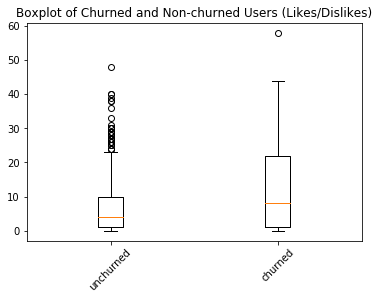

In [36]:
data = [np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 0]['HomeVisits']), \
        np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 1]['HomeVisits'])]

fig2, ax2 = plt.subplots()
#fig2.set_size_inches(18.5, 10.5)
ax2.set_title('Boxplot of Churned and Non-churned Users (Likes/Dislikes)')
ax2.boxplot(data)
ax2.set_xticklabels(['unchurned', 'churned'] , rotation= 45)
plt.show()

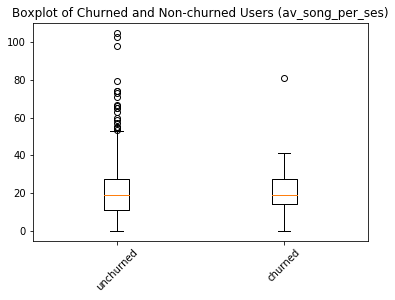

In [37]:
stt_tbl_pd['av_song_per_ses'] = (stt_tbl_pd['listenedSongs'] / stt_tbl_pd['HomeVisits']).fillna(0)

data = [np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 0]['av_song_per_ses']), \
        np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 1]['av_song_per_ses'])]

fig2, ax2 = plt.subplots()
#fig2.set_size_inches(18.5, 10.5)
ax2.set_title('Boxplot of Churned and Non-churned Users (av_song_per_ses)')
ax2.boxplot(data)
ax2.set_xticklabels(['unchurned', 'churned'] , rotation= 45)
plt.show()

Average songs listened home-to-home does not seem to create a remarkable difference.

Another feaute can be the online days of user for last some period.

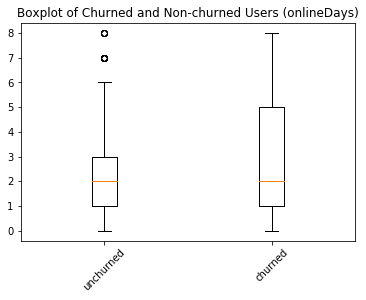

In [38]:
data = [np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 0]['onlineDays']), \
        np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 1]['onlineDays'])]

fig2, ax2 = plt.subplots()
ax2.set_title('Boxplot of Churned and Non-churned Users (onlineDays)')
ax2.boxplot(data)
ax2.set_xticklabels(['unchurned', 'churned'] , rotation= 45)
plt.show()


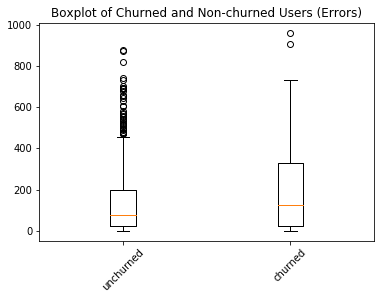

In [39]:
data = [np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 0]['Errors']), \
        np.array(stt_tbl_pd[stt_tbl_pd['ifChurned'] == 1]['Errors'])]

fig2, ax2 = plt.subplots()
ax2.set_title('Boxplot of Churned and Non-churned Users (Errors)')
ax2.boxplot(data)
ax2.set_xticklabels(['unchurned', 'churned'] , rotation= 45)
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Here I will extract only features that I need to train my model.
In my opinion, we can follow two method. One of them is to use log table and separate according to the time order.
BUt here I do not follow this method. I will extract the users' features and try to fit this data. This will provide me to getting rid of ordering the time, however I would lose the effect of time in the model.

In [40]:
#Build a spark session
#spark = SparkSession \
#    .builder \
#    .appName("Sparkify") \
#    .getOrCreate()
#
#extract the data from the json file
#path = "mini_sparkify_event_data.json"
#df = spark.read.json(path)
#
#to be able to use spark sql, a temp view is created
#df.createOrReplaceTempView("log_table")

#store the last of the logs to be able to map days. 
#In th actual data today function can be used to predict future instead of collecting this value.
last_day = spark.sql("select to_date(timestamp(max(ts)/1000)) from log_table").collect()[0][0]

##now we are creating two columns:
##dt --> date of log
##mappedDay --> distance days from the last day. In real, this data can stored in a view so no need to calculate each time.
#df = spark.sql('''select *, datediff(to_date('{}'),dt) as mappedDay from
#            (select *, to_date(timestamp(ts/1000)) as dt
#            from log_table) order by ts'''.format(last_day)
#         )
#
##update the log_table
#df.createOrReplaceTempView("log_table")


Initializations has been made till here. Now, we should determine our strategy.
I will build the model according to the three value: number of cycles, train time and test time.

train time: This is the period considered as determinative for churn beaviours. 
test time: This is the prediction time starting from now.
number of cycles: How many times we will go back and build train and time splits.

For example, if we assume, we can predict if a user will churn in the newt 7 days by looking her last 21 days. In this sentence, 7 represents our time time and 21 represents the train time.

                                                                    Past      <--     Today  -->  Future (prediction)
                                                                                                                               |-------------------data----------------|----ifChurn----|(cycle=1)                  :

                                                                                        :
                                                                                        
                |-------------------data----------------|----ifChurn----| (cycle=2)     :
                
                                                                                        :
                                                                                        
                                |-------------------data----------------|----ifChurn----|  (cycle=3)
                                
                                                                                        :
                                                                                        
                                                |---------------testData----------------|--predictChurn--|
                                                
                                                
                                                
Since I want to fit the best model as first step, I will use data of last week as validation data. It means one week ago will be evaluated as today and we will try to guess whether users would churn in last week.

In this model,  feature engineering should be applied in every time interval. Therefore, I will create a function for feature engineering to use in train and test sets creation loops.
 

In [41]:
def FeatureEngineering(users, cycle, train_time=21, test_time=7):
    '''This function is used for feature engineering. These feature will be etracted
    for the given time.
        *onlineDays: number of days that users has interaction with the application
        *likes: number of 'Thumbs Up'
        *dislikes: number of 'Thumbs Down'
        *HomeVisit: how mqany times the user come to page Home
        *differentArtist: number of artist the user has listened.
    INPUT:
        users: spark dataframe that holds active users.
        cycle: integer value that shows which period will be evaluated starting from now.
        train_time: (int) number of days that is considered as affecting churn behaviour
        test_time: (int) number of days that is assumed that users decide whether to churn or not.
    OUTPUT:
        agg_table: spark dataframe that hold every user and its features in a seperate column for 
        the given cycle, train time and test time.
    
    '''
    #First initialize the edge dates
    last_day = cycle * test_time
    first_day = cycle * test_time + train_time + test_time
    origin = cycle * test_time + test_time
    
    #label table will hold whether the users churn 'test_time' days after the origin.
    label_table = spark.sql('''select userId, {} as cycle,
    sum(case when page == 'Cancellation Confirmation' then 1 else 0 end) as ifChurned
    from log_table
    where mappedDay < {} and mappedDay >= {}
    group by userId '''.format(cycle, origin, last_day))    
    
    #there will be users who churn in train period. It will be meaningless to include these users.
    #Therefore these users will be excluded.
    churned_users = spark.sql('''select userId from (select userId,
    sum(case when page == 'Cancellation Confirmation' then 1 else 0 end) as ifChurned
    from log_table
    where mappedDay < {} and mappedDay >= {}
    group by userId) where ifChurned=1 '''.format(first_day, origin))
    
    churned_users.createOrReplaceTempView("churnedUsers")
    
    #Here features are stored. If any new feature is decided to be added, it should be done here.
    features_table = spark.sql('''select *, likes/listenedSongs as likeRatio, 
    dislikes/listenedSongs as dislikeRatio, listenedSongs/totalLogs as songRatio, 
    Errors/totalLogs as errorRatio
    from (select userId, count(distinct(dt)) onlineDays,
    sum(case when page == 'Thumbs Up' then 1 else 0 end) as likes,
    sum(case when page == 'Thumbs Down' then 1 else 0 end) as dislikes,
    sum(case when page == 'NextSong' then 1 else 0 end) as listenedSongs,
    sum(case when page == 'Home' then 1 else 0 end) as HomeVisits,
    sum(case when page == 'Error' then 1 else 0 end) as Errors,
    count(distinct(artist)) as differentArtists,
    count(*) as totalLogs
    from log_table
    where mappedDay < {} and mappedDay >= {}
    and userId not in (select userId from churnedUsers)
    group by userId)'''.format(first_day, origin))
    
    users = users.subtract(churned_users)       
    
    
    #create the output dataframe
    #full join of users and feautures table since there can be old users who has no log for the train time
    #and also be new users who only exists in features table.
    #Full join of these two table is lef joined with the label table. Because there may be users who will
    #sign up and churn in the test period. Since we thought origin as today we dont have any knowledge about them yet.
    agg_table = users.join(features_table, on=['userId'], how='full').join(label_table, on=['userId'], how='left').na.fill(0)
    
    instant_users = agg_table.select('userId').distinct() 
    
    return agg_table, instant_users


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Here, I am creating a new function to split the data to train and test data. Last week of the data will be used for validation purposes. For robustness purposes all these values are flexible and input for the function.

In [42]:
def GenerateSplitDf(cycle, train_time=21, test_time=7):
    '''This function will create train and test split for the time series data.
    cycle-1 times feature engineering is applied to get train data and last cycle is for validation
    purposes.
    INPUT:
        cycle: (int) It show how many times we go back to collect data.
        train_time: (int) number of days that is considered as affecting churn behaviour
        test_time: (int) number of days that is assumed that users decide whether to churn or not.
    OUTPUT:
        train: spark dataframe to train a model
        test: spark dataframe to validate the trained model.
    
    '''
    user_tb = spark.sql("select * from (select 3 as userId) where userId=2")
    train = spark.sql("select * from (select 1 as userId, 1 as onlineDays, 1 as likes, \
            1 as dislikes, 1 as listenedSongs, 1 as HomeVisits, 1 as Errors, 1 as differentArtists, \
            1 as totalLogs, 1 as likeRatio, 1 as dislikeRatio,\
            1 as songRatio, 1 as errorRatio, 1 as cycle, 1 as ifChurned) where userId=2")    
    
    for i in reversed(range(cycle)):
        
        new_data, user_tb = FeatureEngineering(user_tb, i, train_time, test_time)
        
        if i == 0:
            test = new_data
        else:
            train = train.union(new_data.select(train.columns))
                    
        
    return train, test

Now, we will split the data and build pipelines.

In [43]:
#creating train and test data.
train, test = GenerateSplitDf(cycle= 4, train_time=20, test_time=10)
#data = GenerateSplitDf(9, train_time=20, test_time=10)
#train, test = data.randomSplit([0.7, 0.3], seed=42)



#build assembler and indexer
assembler = VectorAssembler(inputCols=["onlineDays","likes", "HomeVisits", \
                                       "errorRatio", "listenedSongs", "totalLogs"], outputCol="features")
indexer = StringIndexer(inputCol="ifChurned", outputCol="label")

#first model will be Logistic Regression
lr = LogisticRegression(maxIter=10, threshold=0.3)

In [44]:
#Pipeline is created for logistic regression
pipeline1 = Pipeline(stages=[assembler,indexer, lr])

#building a param grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.threshold,[0.1, 0.15, 0.2]) \
    .build()

#creating the cross validation
crossval1 = CrossValidator(estimator=pipeline1,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)


In [45]:
#lets train the model
model1 = pipeline1.fit(train)
#storing the logistic regression predictions
results1 = model1.transform(test)

Since we are trying to guess churned users F1 scoring is one of the best evaluator for us.
Churned users are consisted so small piece of data, so trying to guess unchurned users is missleading.
For example if 5% of the users churn, and we guess none of the users would churn without any model, we can easily reach to  95% success.
However in F1 scoring, only churned users or users who are predicted to churn are evaluated.
ratio1: ratio of churned users among all churns
ratio2: ratio of churned users among all users who is predict to churn

F1 = 2 * ((1/ratio1)+(1/ratio2))^-1


In [46]:
#We can calculate F1 score in pandas
results1_pd = results1.toPandas()
#store the value and print
f1_lr = f1_score(results1_pd.label, results1_pd.prediction)
print(f1_lr)

0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


We get --- f1 score with cross validated logistic regression model. It looks ---- but we can give better explanations by comparing it with different models.
Now try the same for Decision Tree Classifier and calculate the F1 score.

In [47]:
dtc = DecisionTreeClassifier()

pipeline2 = Pipeline(stages=[assembler,indexer, dtc])

#creating the cross validation
crossval2 = CrossValidator(estimator=pipeline2,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)



In [48]:
model2 = pipeline2.fit(train)
results2 = model2.transform(test)

In [49]:
results2_pd = results2.toPandas()
f1_dtc = f1_score(results2_pd.label, results2_pd.prediction)
print(f1_dtc)

0.0


It look Decision Tree Classifier gives (better/worse) results by comparing to Logistic Regression.
Finally, lets get the scores for random forest classifier.

In [50]:
rfc = RandomForestClassifier()
pipeline3 = Pipeline(stages=[assembler,indexer, rfc])

crossval3 = CrossValidator(estimator=pipeline3,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)


model3 = pipeline3.fit(train)
results3 = model3.transform(test)

In [51]:
#We can calculate F1 score in pandas
results3_pd = results3.toPandas()
#store the value and print
f1_rfc = f1_score(results3_pd.label, results3_pd.prediction)
print(f1_rfc)

0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

A lot of effort does not give any good result. Lets try to recognize what was the problem.

In [54]:
spark.sql('''select userId, dt, mappedDay from log_table where page = 'Cancellation Confirmation' order by dt desc ''').show()

+------+----------+---------+
|userId|        dt|mappedDay|
+------+----------+---------+
|100007|2018-11-29|        4|
|100021|2018-11-25|        8|
|100015|2018-11-24|        9|
|300001|2018-11-23|       10|
|100014|2018-11-20|       13|
|    53|2018-11-19|       14|
|200020|2018-11-17|       16|
|200016|2018-11-16|       17|
|200017|2018-11-15|       18|
|    70|2018-11-14|       19|
|    54|2018-11-12|       21|
|100022|2018-11-12|       21|
|200015|2018-11-09|       24|
|    28|2018-11-06|       27|
|   103|2018-11-04|       29|
|100013|2018-11-02|       31|
|200011|2018-11-02|       31|
|200018|2018-11-02|       31|
|   106|2018-11-02|       31|
|200021|2018-11-02|       31|
+------+----------+---------+
only showing top 20 rows



As can be seen, in the test stage there are so few churned users. We just try to guess three users while working with 10-days test data. Lets proof this.

In [55]:
results1_pd[results1_pd['prediction'] == 1][['label', 'prediction']]

,label,prediction


In [58]:
results1_pd.count()

userId              155
onlineDays          155
likes               155
dislikes            155
listenedSongs       155
HomeVisits          155
Errors              155
differentArtists    155
totalLogs           155
likeRatio           155
dislikeRatio        155
songRatio           155
errorRatio          155
cycle               155
ifChurned           155
features            155
label               155
rawPrediction       155
probability         155
prediction          155
dtype: int64

As an example, look logistic regression model's results. Only the rows affecting the F1 score is extractedç

In [72]:
results1_pd[(results1_pd['prediction'] == 1) | (results1_pd['ifChurned'] == 1)][['userId','cycle', 'ifChurned', 'label', 'rawPrediction', 'probability', 'prediction']].head(10)

,userId,cycle,ifChurned,label,rawPrediction,probability,prediction
9,100021,0,1,1.0,"[3.81047931043, -3.81047931043]","[0.978341892137, 0.0216581078631]",0.0
46,100007,0,1,1.0,"[3.48374464167, -3.48374464167]","[0.97022169942, 0.0297783005802]",0.0
65,100015,0,1,1.0,"[3.35433972538, -3.35433972538]","[0.966246658615, 0.0337533413851]",0.0


Predictions are so far away from the truth. This is caused by the difficulty of real world problem and limited data. These three churned users can show different trends than trained ones. Lets look at one of them.

In [73]:
spark.sql("select dt, userId, page, level, gender from log_Table where userId = 100021 order by ts ").collect()

[Row(dt=datetime.date(2018, 10, 11), userId='100021', page='NextSong', level='free', gender='M'),
 Row(dt=datetime.date(2018, 10, 11), userId='100021', page='Roll Advert', level='free', gender='M'),
 Row(dt=datetime.date(2018, 10, 11), userId='100021', page='NextSong', level='free', gender='M'),
 Row(dt=datetime.date(2018, 10, 11), userId='100021', page='Thumbs Up', level='free', gender='M'),
 Row(dt=datetime.date(2018, 10, 11), userId='100021', page='NextSong', level='free', gender='M'),
 Row(dt=datetime.date(2018, 10, 11), userId='100021', page='NextSong', level='free', gender='M'),
 Row(dt=datetime.date(2018, 10, 11), userId='100021', page='NextSong', level='free', gender='M'),
 Row(dt=datetime.date(2018, 10, 11), userId='100021', page='Thumbs Up', level='free', gender='M'),
 Row(dt=datetime.date(2018, 10, 11), userId='100021', page='NextSong', level='free', gender='M'),
 Row(dt=datetime.date(2018, 10, 11), userId='100021', page='NextSong', level='free', gender='M'),
 Row(dt=datetim

User 100021 is not so active till the last day. So it is probably does not have any log in the test period. Again, there should be many users who neither churn nor show any activity, and so these types of users trained as not to be churned.
As a conclusion, these features are needed to be improved and larger dataset is required. 